##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using text and neural network features

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/universal-sentence-encoder/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>


Welcome to the **Intermediate Colab** for **TensorFlow Decision Forests** (**TF-DF**).
In this colab, you will learn about some more advanced capabilities of **TF-DF**, including how to deal with natural language features.

This colab assumes you are familiar with the concepts presented the [Beginner colab](beginner_colab.ipynb), notably about the installation about TF-DF.

In this colab, you will:

1. Train a Random Forest that consumes text features natively as categorical sets.

1. Train a Random Forest that consumes text features using a [TensorFlow Hub](https://www.tensorflow.org/hub) module. In this setting (transfer learning), the module is already pre-trained on a large text corpus.

1. Train a Gradient Boosted Decision Trees (GBDT) and a Neural Network together. The GBDT will consume the output of the Neural Network.

## Setup

In [2]:
# Install TensorFlow Dececision Forests
!pip install tensorflow_decision_forests

  Using cached tensorflow_decision_forests-1.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.2 MB)


  Using cached wurlitzer-3.0.3-py3-none-any.whl (7.3 kB)


[Wurlitzer](https://pypi.org/project/wurlitzer/) is needed to display the detailed training logs in Colabs (when using `verbose=2` in the model constructor).

In [3]:
!pip install wurlitzer

Import the necessary libraries.

In [4]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

2022-12-14 12:26:53.288099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 12:26:53.288187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 12:26:53.288197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


The hidden code cell limits the output height in colab.

In [5]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

## Use raw text as features

TF-DF can consume [categorical-set](https://arxiv.org/pdf/2009.09991.pdf) features natively. Categorical-sets represent text features as bags of words (or n-grams).

For example: `"The little blue dog" ` → `{"the", "little", "blue", "dog"}`

In this example, you'll will train a Random Forest on the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) (SST) dataset. The objective of this dataset is to classify sentences as carrying a *positive* or *negative* sentiment. You'll will use the binary classification version of the dataset curated in [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/glue#gluesst2).

**Note:** Categorical-set features can be expensive to train. In this colab, we will train a small Random Forest with 20 trees.

In [6]:
# Install the TensorFlow Datasets package
!pip install tensorflow-datasets -U --quiet

In [7]:
# Load the dataset
import tensorflow_datasets as tfds
all_ds = tfds.load("glue/sst2")

# Display the first 3 examples of the test fold.
for example in all_ds["test"].take(3):
  print({attr_name: attr_tensor.numpy() for attr_name, attr_tensor in example.items()})

{'idx': 163, 'label': -1, 'sentence': b'not even the hanson brothers can save it'}
{'idx': 131, 'label': -1, 'sentence': b'strong setup and ambitious goals fade as the film descends into unsophisticated scare tactics and b-film thuggery .'}
{'idx': 1579, 'label': -1, 'sentence': b'too timid to bring a sense of closure to an ugly chapter of the twentieth century .'}


2022-12-14 12:27:00.814762: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


The dataset is modified as follows:

1. The raw labels are integers in `{-1, 1}`, but the learning algorithm expects positive integer labels e.g. `{0, 1}`. Therefore, the labels are transformed as follows: `new_labels = (original_labels + 1) / 2`.
1. A batch-size of 64 is applied to make reading the dataset more efficient.
1. The `sentence` attribute needs to be tokenized, i.e. `"hello world" -> ["hello", "world"]`.


**Note:** This example doesn't use the `test` split of the dataset as it does not have labels. If `test` split had labels, you could concatenate the `validation` fold into the `train` one (e.g. `all_ds["train"].concatenate(all_ds["validation"])`).

**Details:** Some decision forest learning algorithms do not need a validation dataset (e.g. Random Forests) while others do (e.g. Gradient Boosted Trees in some cases). Since each learning algorithm under TF-DF can use validation data differently, TF-DF handles train/validation splits internally. As a result, when you have a training and validation sets, they can always be concatenated as input to the learning algorithm.

In [8]:
def prepare_dataset(example):
  label = (example["label"] + 1) // 2
  return {"sentence" : tf.strings.split(example["sentence"])}, label

train_ds = all_ds["train"].batch(100).map(prepare_dataset)
test_ds = all_ds["validation"].batch(100).map(prepare_dataset)

Finally, train and evaluate the model as usual. TF-DF  automatically detects multi-valued categorical features as categorical-set.


In [9]:
%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=30, verbose=2)

# Train the model.
model_1.fit(x=train_ds)

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmphu2_sam9 as temporary training directory


Reading training dataset...


Training tensor examples:
Features: {'sentence': tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64))}
Label: Tensor("data_2:0", shape=(None,), dtype=int64)
Weights: None


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Normalized tensor features:
 {'sentence': SemanticTensor(semantic=<Semantic.CATEGORICAL_SET: 4>, tensor=tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64)))}


Training dataset read in 0:00:04.025605. Found 67349 examples.


Training model...


Standard output detected as not visible to the user e.g. running in a notebook. Creating a training log redirection. If training get stuck, try calling tfdf.keras.set_training_logs_redirection(False).


[INFO 2022-12-14T12:27:04.990434083+00:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2022-12-14T12:27:04.99053593+00:00 kernel.cc:815] Collect training examples
[INFO 2022-12-14T12:27:04.990584568+00:00 kernel.cc:423] Number of batches: 674
[INFO 2022-12-14T12:27:04.99059974+00:00 kernel.cc:424] Number of examples: 67349


[INFO 2022-12-14T12:27:05.036257848+00:00 data_spec_inference.cc:303] 12816 item(s) have been pruned (i.e. they are considered out of dictionary) for the column sentence (2000 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000


[INFO 2022-12-14T12:27:05.085701878+00:00 kernel.cc:837] Training dataset:
Number of records: 67349
Number of columns: 2

Number of columns by type:
	CATEGORICAL_SET: 1 (50%)
	CATEGORICAL: 1 (50%)

Columns:

CATEGORICAL_SET: 1 (50%)
	0: "sentence" CATEGORICAL_SET has-dict vocab-size:2001 num-oods:3595 (5.33787%) most-frequent:"the" 27205 (40.3941%)

CATEGORICAL: 1 (50%)
	1: "__LABEL" CATEGORICAL integerized vocab-size:3 no-ood-item

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained through tokenization.
	has-dict: The attribute is attached to a string dictionary e.g. a categorical attribute stored as a string.
	vocab-size: Number of unique values.

[INFO 2022-12-14T12:27:05.086130634+00:00 kernel.cc:883] Configure learner


[INFO 2022-12-14T12:27:05.086528637+00:00 kernel.cc:913] Training config:
learner: "RANDOM_FOREST"
features: "sentence"
label: "__LABEL"
task: CLASSIFICATION
random_seed: 123456
metadata {
  framework: "TF Keras"
}
pure_serving_model: false
[yggdrasil_decision_forests.model.random_forest.proto.random_forest_config] {
  num_trees: 30
  decision_tree {
    max_depth: 16
    min_examples: 5
    in_split_min_examples_check: true
    keep_non_leaf_label_distribution: true
    num_candidate_attributes: 0
    missing_value_policy: GLOBAL_IMPUTATION
    allow_na_conditions: false
    categorical_set_greedy_forward {
      sampling: 0.1
      max_num_items: -1
      min_item_frequency: 1
    }
    growing_strategy_local {
    }
    categorical {
      cart {
      }
    }
    axis_aligned_split {
    }
    internal {
      sorting_strategy: PRESORTED
    }
    uplift {
      min_examples_in_treatment: 5
      split_score: KULLBACK_LEIBLER
    }
  }
  winner_take_all_inference: true
  compute_oo

ompute_oob_variable_importances: false
  num_oob_variable_importances_permutations: 1
  bootstrap_training_dataset: true
  bootstrap_size_ratio: 1
  adapt_bootstrap_size_ratio_for_maximum_training_duration: false
  sampling_with_replacement: true
}

[INFO 2022-12-14T12:27:05.086856196+00:00 kernel.cc:916] Deployment config:
cache_path: "/tmpfs/tmp/tmphu2_sam9/working_cache"
num_threads: 32
try_resume_training: true

[INFO 2022-12-14T12:27:05.086877633+00:00 kernel.cc:945] Train model
[INFO 2022-12-14T12:27:05.087420068+00:00 random_forest.cc:407] Training random forest on 67349 example(s) and 1 feature(s).


[INFO 2022-12-14T12:27:35.305049704+00:00 random_forest.cc:796] Training of tree  1/30 (tree index:0) done accuracy:0.748203 logloss:9.07568


[INFO 2022-12-14T12:27:45.316968404+00:00 random_forest.cc:796] Training of tree  4/30 (tree index:15) done accuracy:0.76641 logloss:7.02115


[INFO 2022-12-14T12:27:49.159394601+00:00 random_forest.cc:796] Training of tree  14/30 (tree index:19) done accuracy:0.80373 logloss:2.217


[INFO 2022-12-14T12:27:50.270043625+00:00 random_forest.cc:796] Training of tree  24/30 (tree index:18) done accuracy:0.815421 logloss:1.11463


[INFO 2022-12-14T12:27:52.305473703+00:00 random_forest.cc:796] Training of tree  30/30 (tree index:21) done accuracy:0.821274 logloss:0.854486
[INFO 2022-12-14T12:27:52.30590867+00:00 random_forest.cc:876] Final OOB metrics: accuracy:0.821274 logloss:0.854486


[INFO 2022-12-14T12:27:52.314905793+00:00 kernel.cc:962] Export model in log directory: /tmpfs/tmp/tmphu2_sam9 with prefix 00ad89243e824146


[INFO 2022-12-14T12:27:52.347302203+00:00 kernel.cc:979] Save model in resources


[INFO 2022-12-14T12:27:52.349904758+00:00 abstract_model.cc:844] Model self evaluation:
Number of predictions (without weights): 67349
Number of predictions (with weights): 67349
Task: CLASSIFICATION
Label: __LABEL

Accuracy: 0.821274  CI95[W][0.818828 0.8237]
LogLoss: : 0.854486
ErrorRate: : 0.178726

Default Accuracy: : 0.557826
Default LogLoss: : 0.686445
Default ErrorRate: : 0.442174

Confusion Table:
truth\prediction
   0      1      2
0  0      0      0
1  0  19593  10187
2  0   1850  35719
Total: 67349

One vs other classes:



[INFO 2022-12-14T12:27:52.374670455+00:00 kernel.cc:1175] Loading model from path /tmpfs/tmp/tmphu2_sam9/model/ with prefix 00ad89243e824146


[INFO 2022-12-14T12:27:52.609599069+00:00 decision_forest.cc:640] Model loaded with 30 root(s), 43180 node(s), and 1 input feature(s).
[INFO 2022-12-14T12:27:52.609642043+00:00 abstract_model.cc:1306] Engine "RandomForestGeneric" built
[INFO 2022-12-14T12:27:52.609672074+00:00 kernel.cc:1021] Use fast generic engine


Model trained in 0:00:47.633069


Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model compiled.


In the previous logs, note that `sentence` is a `CATEGORICAL_SET` feature.

The model is evaluated as usual:

In [10]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

1/9 [==>...........................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.8100

9/9 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.7638


BinaryCrossentropyloss: 0.0
Accuracy: 0.7637614607810974


The training logs looks are follow:

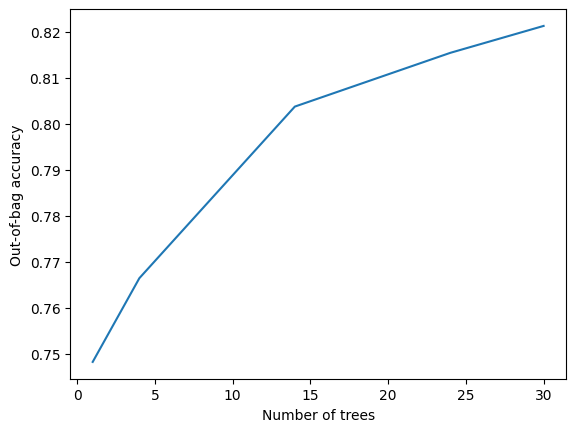

In [11]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

More trees would probably be beneficial (I am sure of it because I tried :p).

## Use a pretrained text embedding

The previous example trained a Random Forest using raw text features. This example will use a pre-trained TF-Hub embedding to convert text features into a dense embedding, and then train a Random Forest on top of it. In this situation, the Random Forest will only "see" the numerical output of the embedding (i.e. it will not see the raw text). 

In this experiment,  will use the [Universal-Sentence-Encoder](https://tfhub.dev/google/universal-sentence-encoder/4). Different pre-trained embeddings might be suited for different types of text (e.g. different language, different task) but also for other type of structured features (e.g. images).

**Note:** This embedding is large (1GB) and therefore the final model will be slow to run (compared to classical decision tree inference).

The embedding module can be applied in one of two places:

1. During the dataset preparation.
2. In the pre-processing stage of the model.

The second option is often preferable: Packaging the embedding in the model makes the model easier to use (and harder to misuse).

First install TF-Hub:

In [12]:
!pip install --upgrade tensorflow-hub

Unlike before, you don't need to tokenize the text.

In [13]:
def prepare_dataset(example):
  label = (example["label"] + 1) // 2
  return {"sentence" : example["sentence"]}, label

train_ds = all_ds["train"].batch(100).map(prepare_dataset)
test_ds = all_ds["validation"].batch(100).map(prepare_dataset)


In [14]:
%set_cell_height 300

import tensorflow_hub as hub
# NNLM (https://tfhub.dev/google/nnlm-en-dim128/2) is also a good choice.
hub_url = "http://tfhub.dev/google/universal-sentence-encoder/4"
embedding = hub.KerasLayer(hub_url)

sentence = tf.keras.layers.Input(shape=(), name="sentence", dtype=tf.string)
embedded_sentence = embedding(sentence)

raw_inputs = {"sentence": sentence}
processed_inputs = {"embedded_sentence": embedded_sentence}
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

model_2 = tfdf.keras.RandomForestModel(
    preprocessing=preprocessor,
    num_trees=100)

model_2.fit(x=train_ds)

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmpee3xdlt3 as temporary training directory


Reading training dataset...


Training dataset read in 0:00:23.078026. Found 67349 examples.


Training model...


[INFO 2022-12-14T12:28:45.876657299+00:00 kernel.cc:1175] Loading model from path /tmpfs/tmp/tmpee3xdlt3/model/ with prefix c04a078aa16143ed


Model trained in 0:00:13.717666


Compiling model...


[INFO 2022-12-14T12:28:47.652194224+00:00 abstract_model.cc:1306] Engine "RandomForestOptPred" built
[INFO 2022-12-14T12:28:47.652363006+00:00 kernel.cc:1021] Use fast generic engine


Model compiled.


In [15]:
model_2.compile(metrics=["accuracy"])
evaluation = model_2.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

1/9 [==>...........................] - ETA: 13s - loss: 0.0000e+00 - accuracy: 0.7800

4/9 [============>.................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8050 

8/9 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7912

9/9 [==============================] - 2s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7878


BinaryCrossentropyloss: 0.0
Accuracy: 0.7878440618515015


Note that categorical sets represent text differently from a dense embedding, so it may be useful to use both strategies jointly.

## Train a decision tree and neural network together

The previous example used a pre-trained Neural Network (NN) to 
process the text features before passing them to the Random Forest. This example will train both the Neural Network and the Random Forest from scratch.


TF-DF's Decision Forests do not back-propagate gradients ([although this is the subject of ongoing research](https://arxiv.org/abs/2007.14761)). Therefore, the training happens in two stages:

1. Train the neural-network as a standard classification task:

```
example → [Normalize] → [Neural Network*] → [classification head] → prediction
*: Training.
```

2. Replace the Neural Network's head (the last layer and the soft-max) with a Random Forest. Train the Random Forest as usual:

```
example → [Normalize] → [Neural Network] → [Random Forest*] → prediction
*: Training.
```



### Prepare the dataset

This example uses the [Palmer's Penguins](https://allisonhorst.github.io/palmerpenguins/articles/intro.html) dataset. See the [Beginner colab](beginner_colab.ipynb) for details.

First, download the raw data:

In [16]:
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

Load a dataset into a Pandas Dataframe.

In [17]:
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples.
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007



Prepare the dataset for training.

In [18]:
label = "species"

# Replaces numerical NaN (representing missing values in Pandas Dataframe) with 0s.
# ...Neural Nets don't work well with numerical NaNs.
for col in dataset_df.columns:
  if dataset_df[col].dtype not in [str, object]:
    dataset_df[col] = dataset_df[col].fillna(0)

In [19]:
# Split the dataset into a training and testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Convert the datasets into tensorflow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

250 examples in training, 94 examples for testing.


### Build the models

Next create the neural network model using [Keras' functional style](https://www.tensorflow.org/guide/keras/functional). 

To keep the example simple this model only uses two inputs.

In [20]:
input_1 = tf.keras.Input(shape=(1,), name="bill_length_mm", dtype="float")
input_2 = tf.keras.Input(shape=(1,), name="island", dtype="string")

nn_raw_inputs = [input_1, input_2]

Use [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) to convert the raw inputs to inputs appropriate for the neural network. 

In [21]:
# Normalization.
Normalization = tf.keras.layers.Normalization
CategoryEncoding = tf.keras.layers.CategoryEncoding
StringLookup = tf.keras.layers.StringLookup

values = train_ds_pd["bill_length_mm"].values[:, tf.newaxis]
input_1_normalizer = Normalization()
input_1_normalizer.adapt(values)

values = train_ds_pd["island"].values
input_2_indexer = StringLookup(max_tokens=32)
input_2_indexer.adapt(values)

input_2_onehot = CategoryEncoding(output_mode="binary", max_tokens=32)

normalized_input_1 = input_1_normalizer(input_1)
normalized_input_2 = input_2_onehot(input_2_indexer(input_2))

nn_processed_inputs = [normalized_input_1, normalized_input_2]

Build the body of the neural network:

In [22]:
y = tf.keras.layers.Concatenate()(nn_processed_inputs)
y = tf.keras.layers.Dense(16, activation=tf.nn.relu6)(y)
last_layer = tf.keras.layers.Dense(8, activation=tf.nn.relu, name="last")(y)

# "3" for the three label classes. If it were a binary classification, the
# output dim would be 1.
classification_output = tf.keras.layers.Dense(3)(y)

nn_model = tf.keras.models.Model(nn_raw_inputs, classification_output)

This `nn_model` directly produces classification logits. 

Next create a decision forest model. This will operate on the high level features that the neural network extracts in the last layer before that classification head.

In [23]:
# To reduce the risk of mistakes, group both the decision forest and the
# neural network in a single keras model.
nn_without_head = tf.keras.models.Model(inputs=nn_model.inputs, outputs=last_layer)
df_and_nn_model = tfdf.keras.RandomForestModel(preprocessing=nn_without_head)

Use /tmpfs/tmp/tmpgtjvez1v as temporary training directory


### Train and evaluate the models

The model will be trained in two stages. First train the neural network with its own classification head:

In [24]:
%set_cell_height 300

nn_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])

nn_model.fit(x=train_ds, validation_data=test_ds, epochs=10)
nn_model.summary()

<IPython.core.display.Javascript object>

Epoch 1/10


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - ETA: 0s - loss: 1.1437 - accuracy: 0.4520

1/1 [==============================] - 1s 1s/step - loss: 1.1437 - accuracy: 0.4520 - val_loss: 1.1605 - val_accuracy: 0.4255


Epoch 2/10


1/1 [==============================] - ETA: 0s - loss: 1.1398 - accuracy: 0.4640

1/1 [==============================] - 0s 20ms/step - loss: 1.1398 - accuracy: 0.4640 - val_loss: 1.1567 - val_accuracy: 0.4255


Epoch 3/10


1/1 [==============================] - ETA: 0s - loss: 1.1360 - accuracy: 0.4640

1/1 [==============================] - 0s 19ms/step - loss: 1.1360 - accuracy: 0.4640 - val_loss: 1.1529 - val_accuracy: 0.4255


Epoch 4/10


1/1 [==============================] - ETA: 0s - loss: 1.1321 - accuracy: 0.4760

1/1 [==============================] - 0s 20ms/step - loss: 1.1321 - accuracy: 0.4760 - val_loss: 1.1491 - val_accuracy: 0.4255


Epoch 5/10


1/1 [==============================] - ETA: 0s - loss: 1.1283 - accuracy: 0.4800

1/1 [==============================] - 0s 19ms/step - loss: 1.1283 - accuracy: 0.4800 - val_loss: 1.1454 - val_accuracy: 0.4255


Epoch 6/10


1/1 [==============================] - ETA: 0s - loss: 1.1246 - accuracy: 0.4840

1/1 [==============================] - 0s 20ms/step - loss: 1.1246 - accuracy: 0.4840 - val_loss: 1.1416 - val_accuracy: 0.4362


Epoch 7/10


1/1 [==============================] - ETA: 0s - loss: 1.1208 - accuracy: 0.4840

1/1 [==============================] - 0s 18ms/step - loss: 1.1208 - accuracy: 0.4840 - val_loss: 1.1379 - val_accuracy: 0.4362


Epoch 8/10


1/1 [==============================] - ETA: 0s - loss: 1.1171 - accuracy: 0.4920

1/1 [==============================] - 0s 19ms/step - loss: 1.1171 - accuracy: 0.4920 - val_loss: 1.1342 - val_accuracy: 0.4362


Epoch 9/10


1/1 [==============================] - ETA: 0s - loss: 1.1134 - accuracy: 0.4920

1/1 [==============================] - 0s 19ms/step - loss: 1.1134 - accuracy: 0.4920 - val_loss: 1.1305 - val_accuracy: 0.4468


Epoch 10/10


1/1 [==============================] - ETA: 0s - loss: 1.1097 - accuracy: 0.5040

1/1 [==============================] - 0s 19ms/step - loss: 1.1097 - accuracy: 0.5040 - val_loss: 1.1268 - val_accuracy: 0.4468


Model: "model_1"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 island (InputLayer)            [(None, 1)]          0           []                               


 bill_length_mm (InputLayer)    [(None, 1)]          0           []                               


 string_lookup (StringLookup)   (None, 1)            0           ['island[0][0]']                 


 normalization (Normalization)  (None, 1)            3           ['bill_length_mm[0][0]']         


 category_encoding (CategoryEnc  (None, 32)          0           ['string_lookup[0][0]']          


 oding)                                                                                           


 concatenate (Concatenate)      (None, 33)           0           ['normalization[0][0]',          


                                                                  'category_encoding[0][0]']      


 dense (Dense)                  (None, 16)           544         ['concatenate[0][0]']            


 dense_1 (Dense)                (None, 3)            51          ['dense[0][0]']                  


Total params: 598


Trainable params: 595


Non-trainable params: 3


__________________________________________________________________________________________________


The neural network layers are shared between the two models. So now that the neural network is trained the decision forest model will be fit to the trained output of the neural network layers:

In [25]:
%set_cell_height 300

df_and_nn_model.fit(x=train_ds)

<IPython.core.display.Javascript object>

Reading training dataset...


Training dataset read in 0:00:00.274756. Found 250 examples.


Training model...


Model trained in 0:00:00.040962


Compiling model...


Model compiled.


[INFO 2022-12-14T12:28:56.117963516+00:00 kernel.cc:1175] Loading model from path /tmpfs/tmp/tmpgtjvez1v/model/ with prefix 5c5b778b01794a57
[INFO 2022-12-14T12:28:56.132571111+00:00 kernel.cc:1021] Use fast generic engine


Now evaluate the composed model:

In [26]:
df_and_nn_model.compile(metrics=["accuracy"])
print("Evaluation:", df_and_nn_model.evaluate(test_ds))

1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.9574

1/1 [==============================] - 0s 155ms/step - loss: 0.0000e+00 - accuracy: 0.9574


Evaluation: [0.0, 0.957446813583374]


Compare it to the Neural Network alone:

In [27]:
print("Evaluation :", nn_model.evaluate(test_ds))

1/1 [==============================] - ETA: 0s - loss: 1.1268 - accuracy: 0.4468

1/1 [==============================] - 0s 12ms/step - loss: 1.1268 - accuracy: 0.4468


Evaluation : [1.1268064975738525, 0.44680851697921753]
